# Hyperparameter tuning - RMSprop optimizer
De volgende dingen worden geprobeerd: 

    - Activation functions: ReLu, LeakyReLu, ELU
    - Learning rate: 0.001, 0.0005, 0.0001
    - Dropout rate: 0.2, 0.5 --> 0.2 werkt beter
    - Loss function: mse, huber, mae

Voor de eerste training ronde trainen we elke setup 3 keer en kijken naar de gemiddelde performance. 
Dan halen we de beste opties eruit en trainen deze nog eens ieder 10 keer en kiezen zo de beste.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, BatchNormalization, Dropout, Concatenate, Activation
from keras.utils import plot_model

C:\Users\liesv\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import dataset

In [2]:
MYwd= os.getcwd()
file_path = MYwd+r"\Data\cause_specific_Short_Reconstructed\USA_m_short_idr.csv"

data = pd.read_csv(file_path)

# deel door 1,000,000 om force of mortality te krijgen
exclude_cols = ['country', 'year', 'sex', 'list', 'agf', 'cause']
data.loc[:, ~data.columns.isin(exclude_cols)] = data.loc[:, ~data.columns.isin(exclude_cols)] / 1000000

# only keep the lines for both sexes: 
subset = data[data['sex'] == 3]
subset = subset.drop(columns=['sex', 'list', 'agf', 'total', 'm85p', 'm90p', 'm95p'])

# nu staat de data in de vorm: country, year, cause, m0, m1, m5, ...
# ik wil de vorm: country, year, cause, age, m

df = subset.melt(id_vars=['country', 'year', 'cause'], var_name='age', value_name='m')
df['age'] = df['age'].str.extract('(\d+)').astype(int)                           # Convert 'age' from 'mX' format to just 'X'
df['log_m'] = np.log(df['m'].replace(0,1e-8))    

# Prepare data to feed into neural network: 
df['cause'] = df['cause'].astype('category').cat.codes      # convert to categorical variable

df['year'] = df['year'].astype('float')    # neural nets prefer floats over ints
df['age'] = df['age'].astype('float')

#### Division in training and test set

In [3]:
# Set up the training set
train = df[(df['year'].between(1979, 2011))]
train = train.copy() 

# Set up the test set
test_set = df[(df['year'].between(2012, 2021))]
test_set = test_set.copy()

## Neural network

In [ ]:
year_mean, year_std = train['year'].mean(), train['year'].std()
age_mean, age_std = train['age'].mean(), train['age'].std()


In [4]:
# function to prepare the dataset and normalize the data

def normalize_temp(data):
    # Extract unique combinations of 'year' and 'age'
    unique_combos = data[['year', 'age']].drop_duplicates()
    
    # Reshape the inputs
    year_arr = unique_combos['year'].values.reshape(-1, 1)
    age_arr = unique_combos['age'].values.reshape(-1, 1)
    
    # Calculate mean and std for each feature
    year_mean, year_std = year_arr.mean(), year_arr.std()
    age_mean, age_std = age_arr.mean(), age_arr.std()
    
    # Normalize the data: (value - mean) / std
    year_norm = (year_arr - year_mean) / year_std
    age_norm = (age_arr - age_mean) / age_std
    
    # Create normalized X_train list
    X = [year_norm, age_norm]
    
    # Prepare Y_train as before
    rows = len(data['log_m'].values) // 17
    Y = data['log_m'].values.reshape(rows, 17)
    return X, Y

In [5]:
# Build the neural network model

def build_model(units=np.array([256, 256]), activation = 'relu', drop=0.2, 
                optimizer='rmsprop', loss_function='mse', learning_rate=0.0005):
    
    # Define the input layers
    year = Input(shape=(1,), dtype='float32', name='year')
    age = Input(shape=(1,), dtype='float32', name='age')
    
    # Concatenate the defined features
    features = Concatenate()([year, age])
    
    x = Dense(units=units[0], activation=activation)(features)
    x = BatchNormalization()(x)
    x = Dropout(drop)(x)
    
    # Define the hidden layers
    for i in range(1, len(units)): 
        x = Dense(units=units[i], activation=activation)(x)
        x = BatchNormalization()(x)
        x = Dropout(drop)(x)
    
    # Define the output layer
    target = Dense(units=17, activation='linear')(x)
    
    model = Model(inputs=[year, age], outputs=target)
    
    opt_dict = {'adam': tf.keras.optimizers.Adam(learning_rate), 
                'rmsprop': tf.keras.optimizers.RMSprop(learning_rate), 
                'sgd': tf.keras.optimizers.SGD(learning_rate)}
    
    model.compile(optimizer=opt_dict[optimizer], loss=loss_function)
    
    return model

calculating for structure [500]


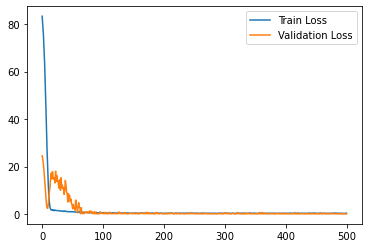

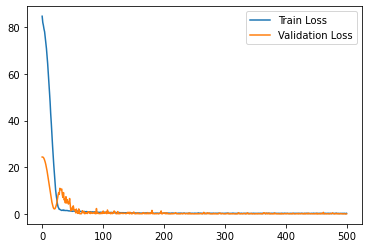

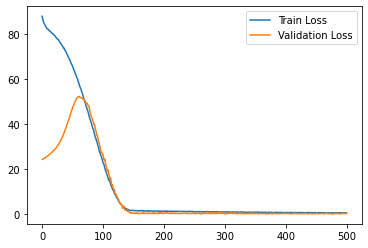

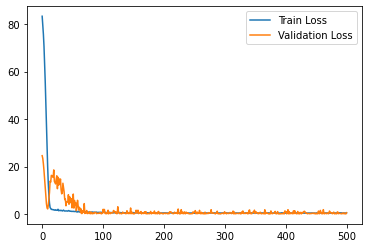

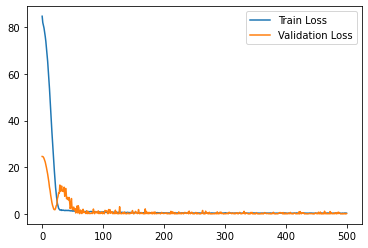

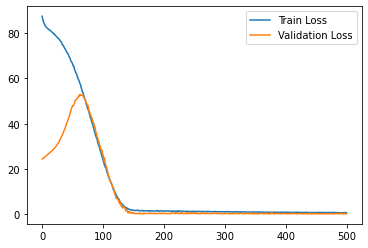

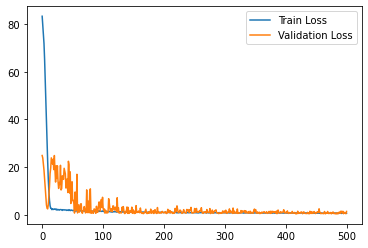

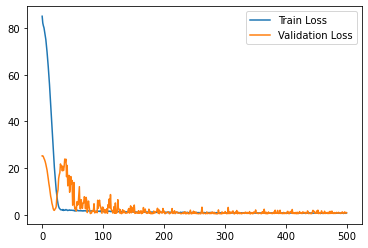

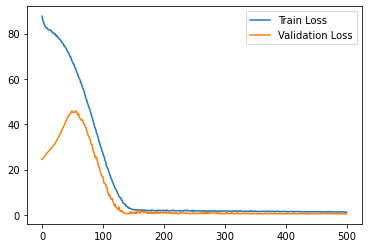

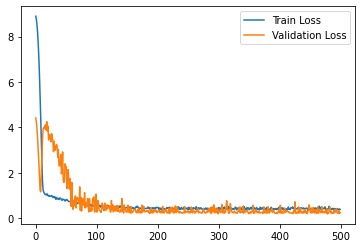

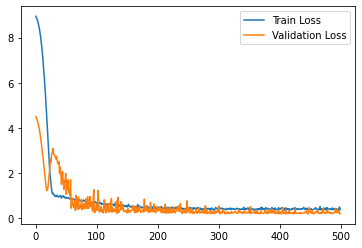

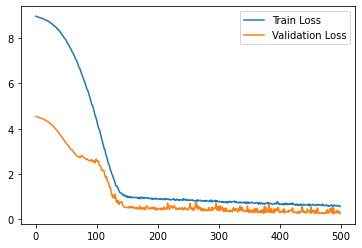

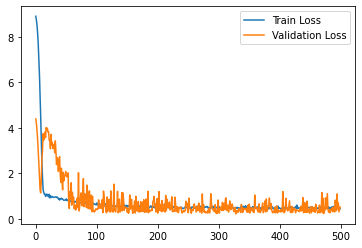

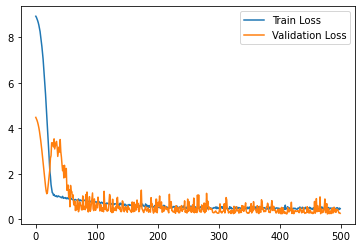

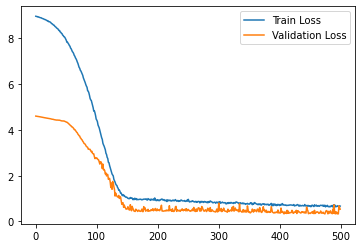

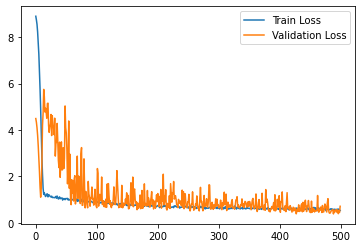

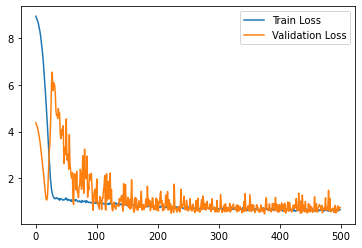

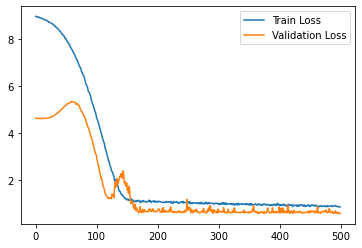

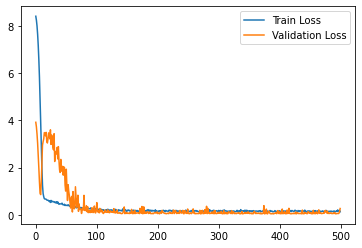

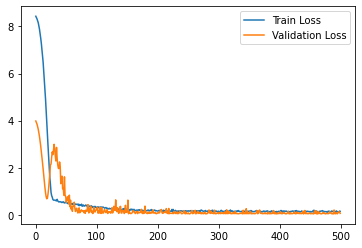

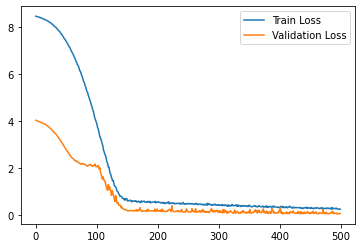

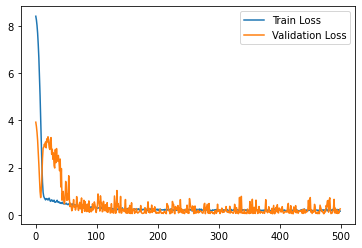

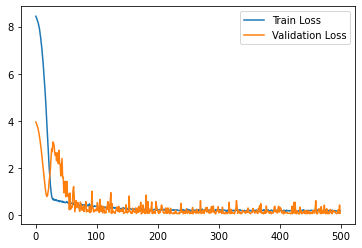

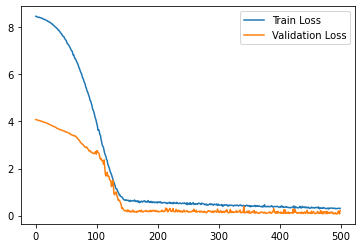

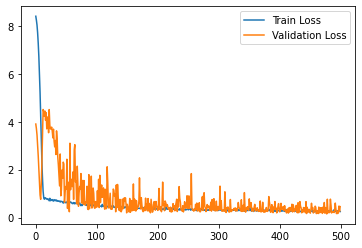

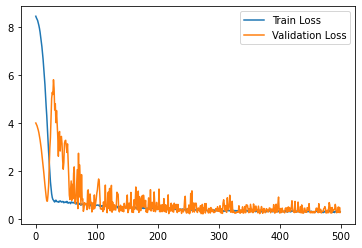

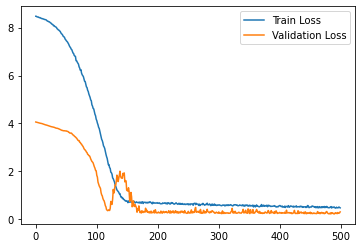

calculating for structure [256]


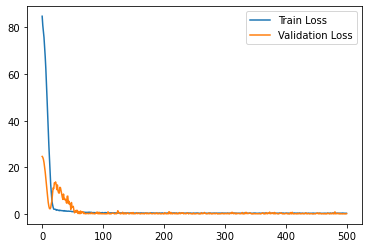

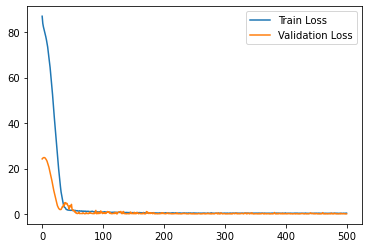

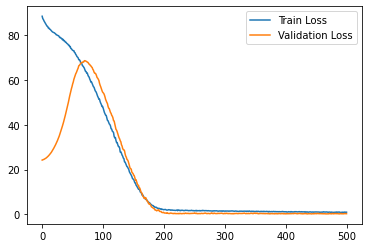

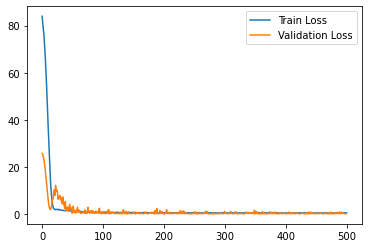

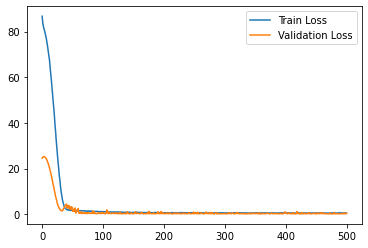

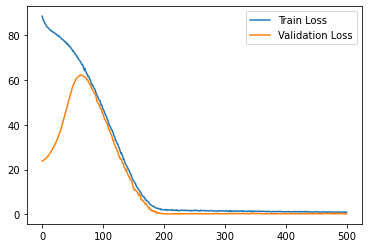

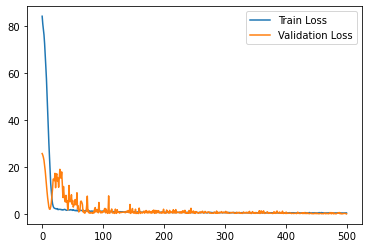

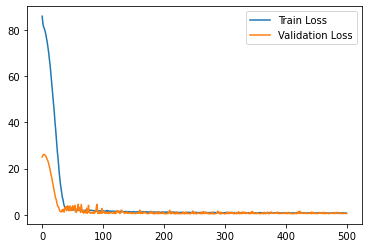

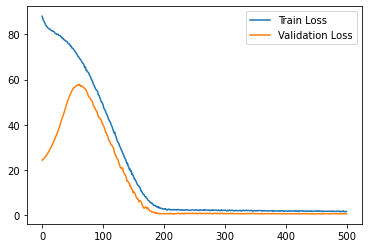

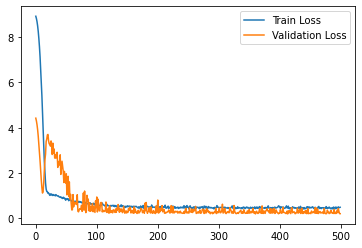

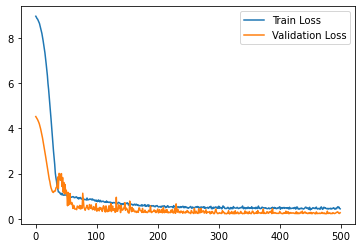

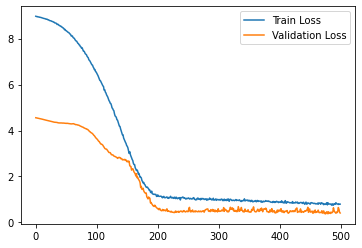

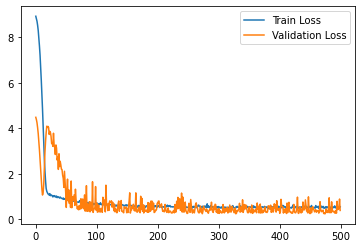

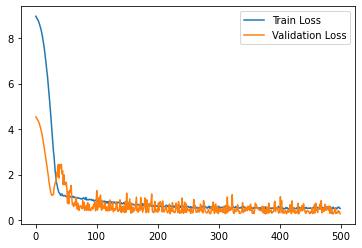

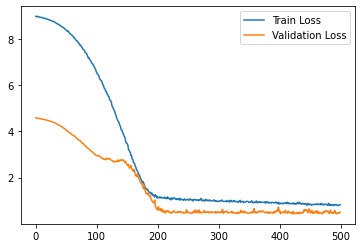

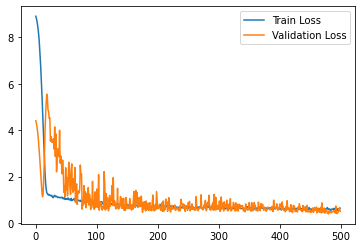

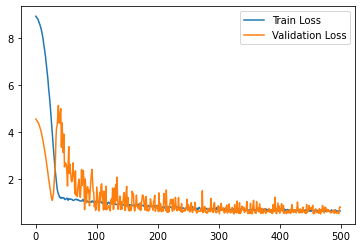

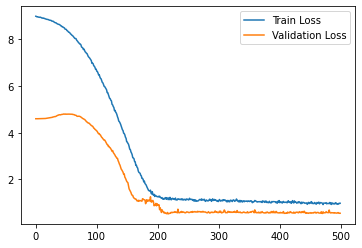

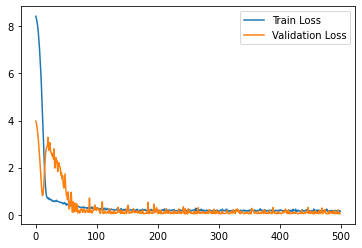

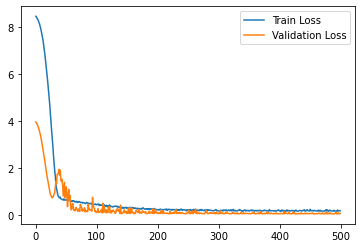

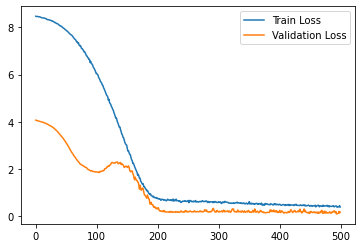

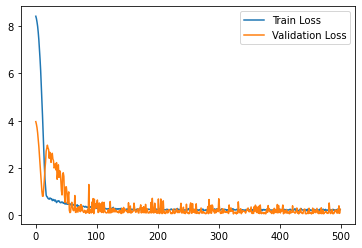

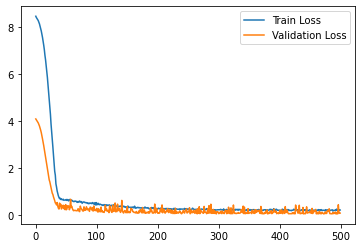

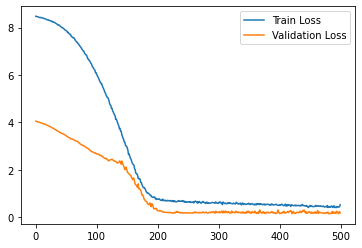

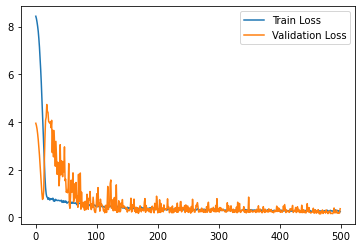

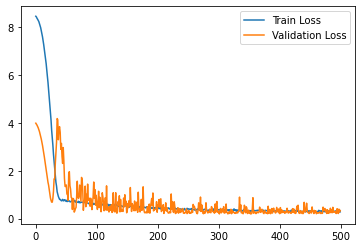

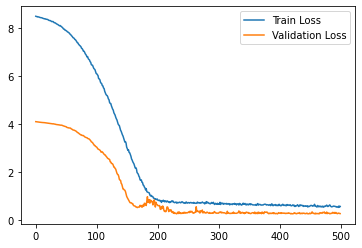

calculating for structure [256 128]


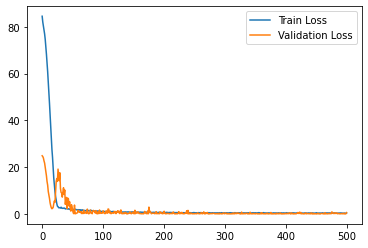

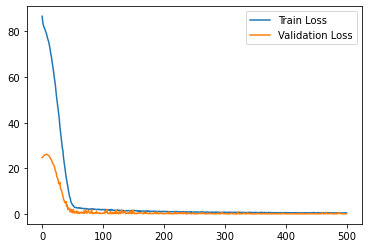

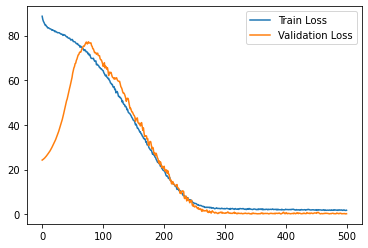

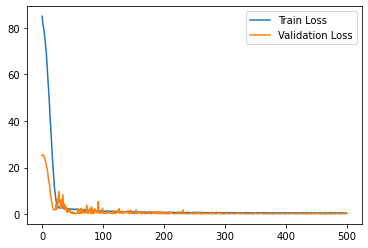

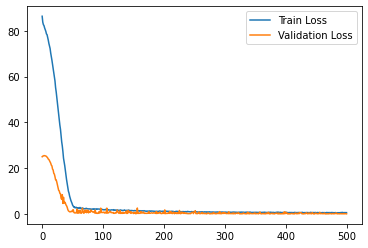

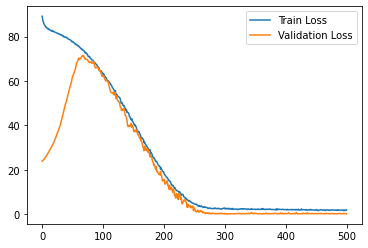

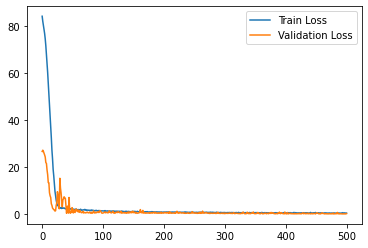

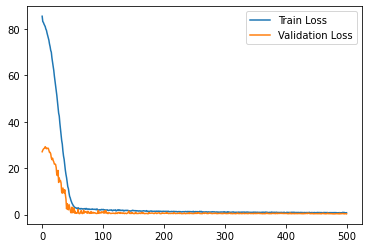

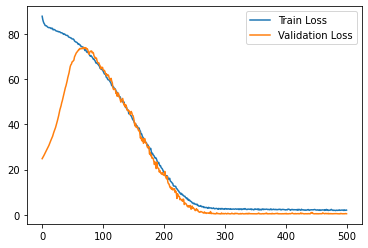

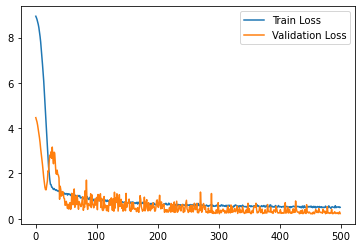

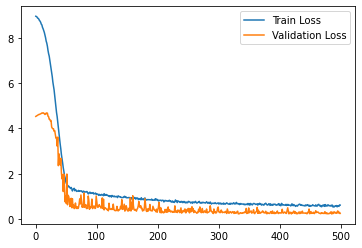

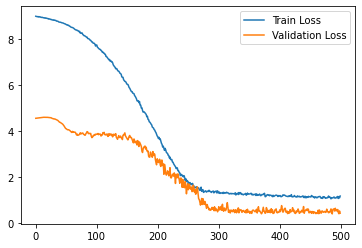

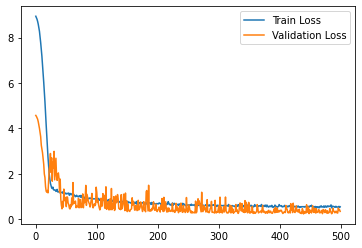

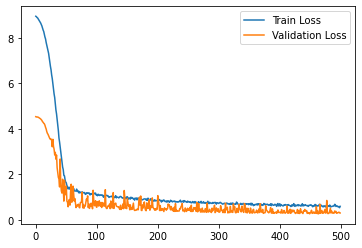

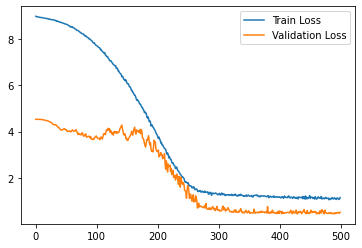

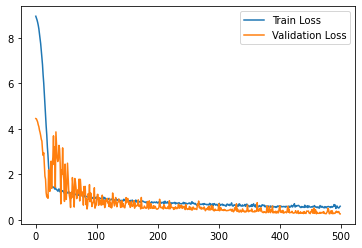

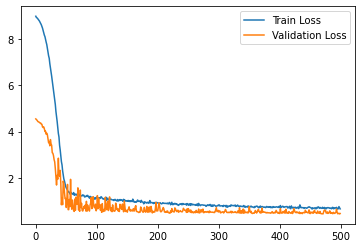

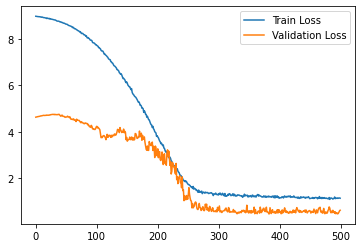

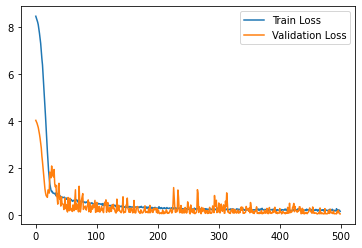

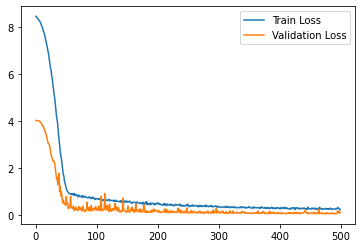

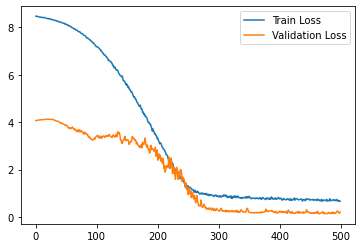

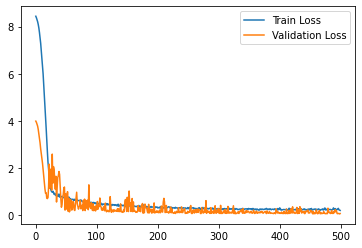

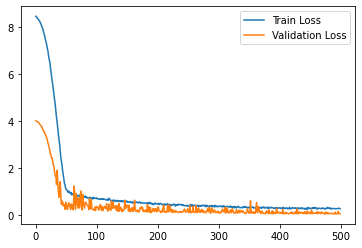

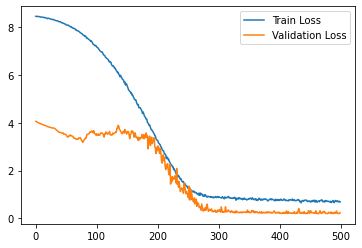

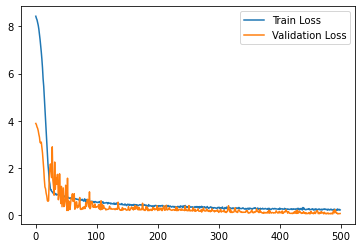

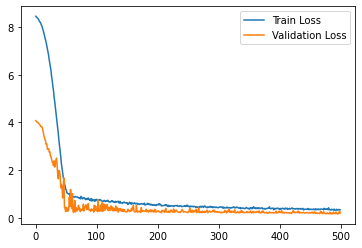

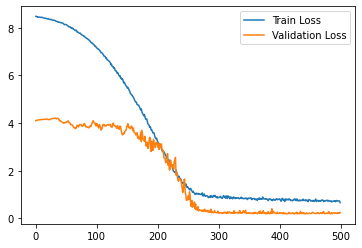

calculating for structure [256 256]


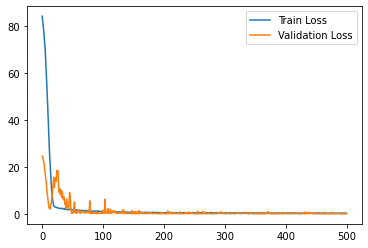

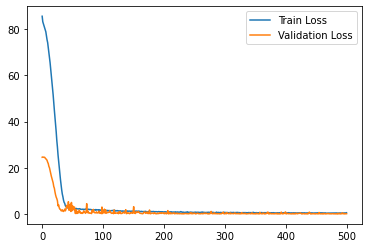

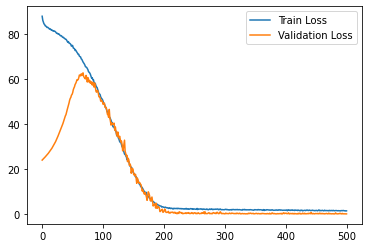

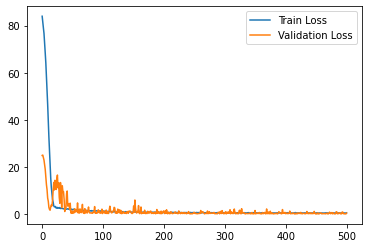

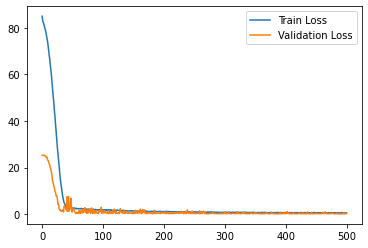

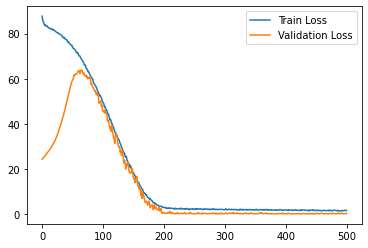

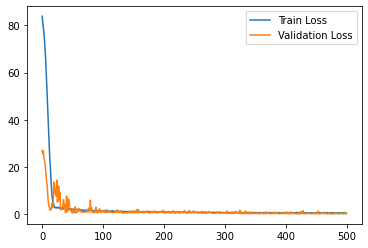

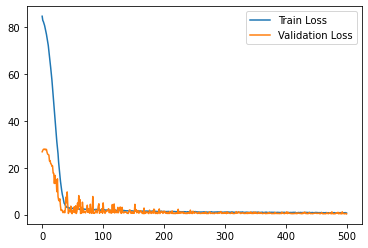

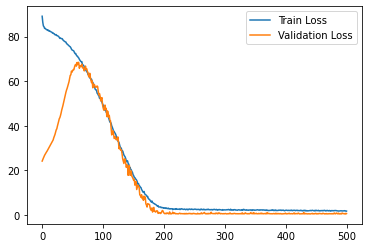

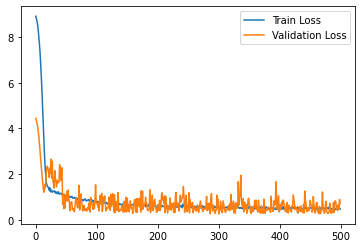

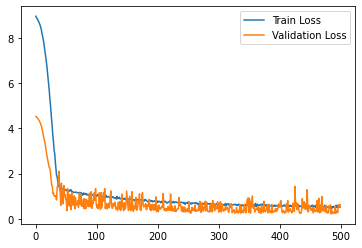

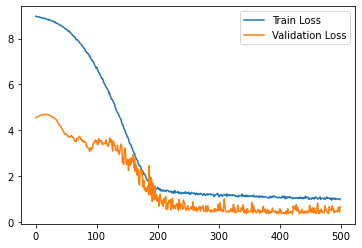

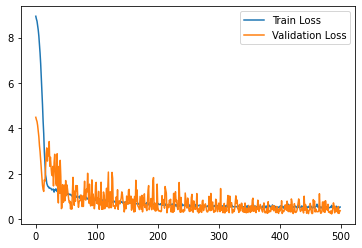

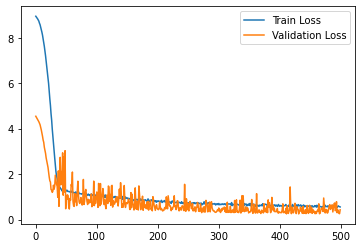

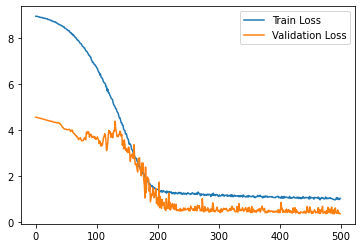

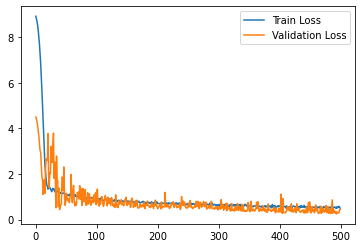

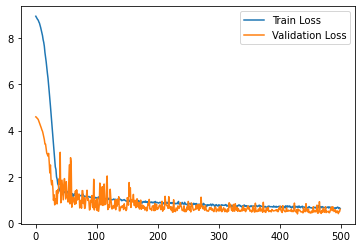

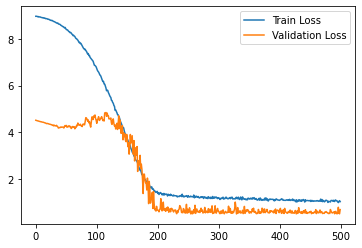

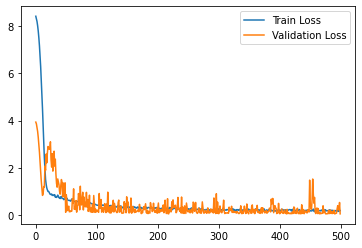

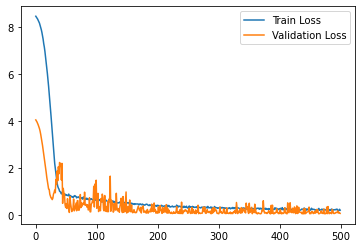

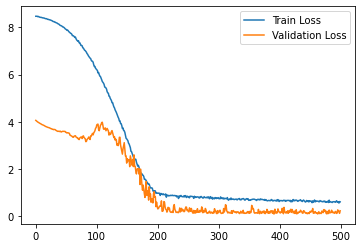

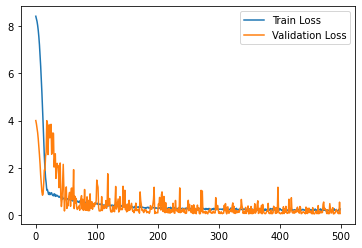

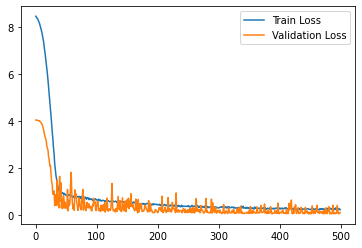

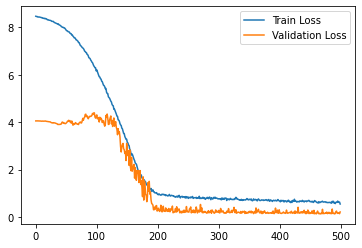

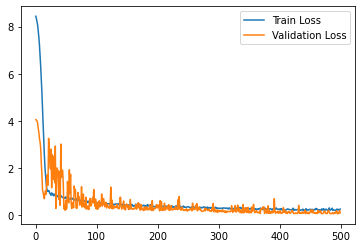

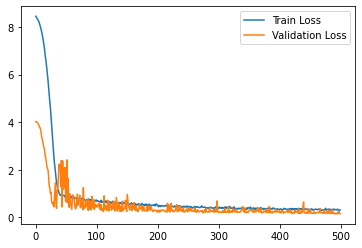

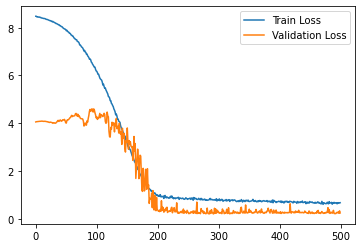

calculating for structure [256 256 256]


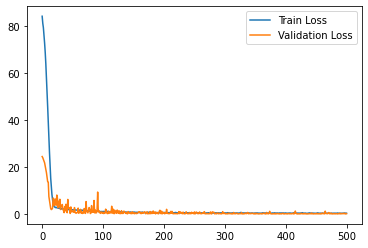

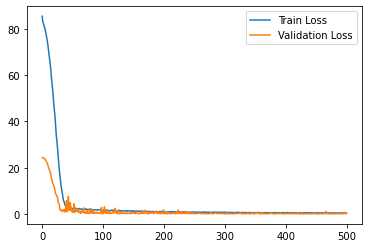

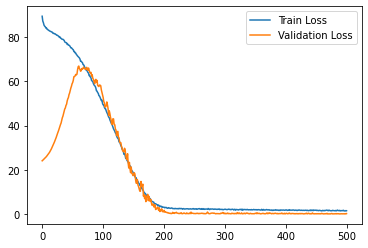

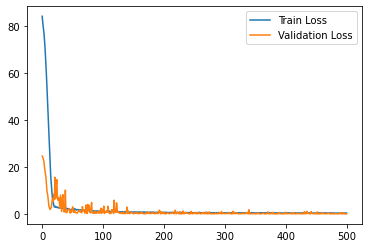

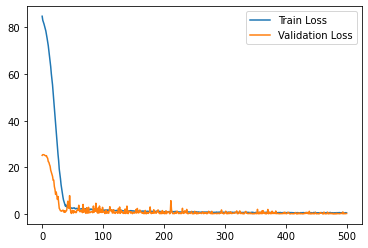

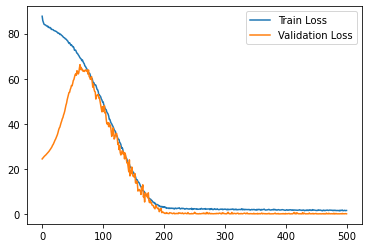

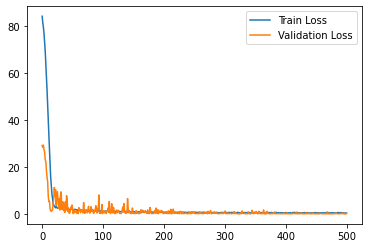

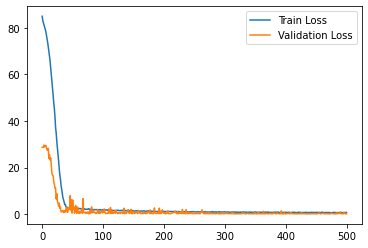

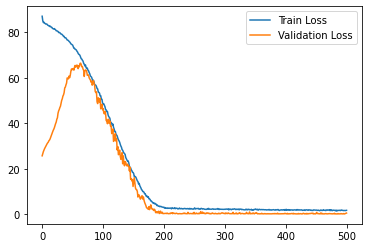

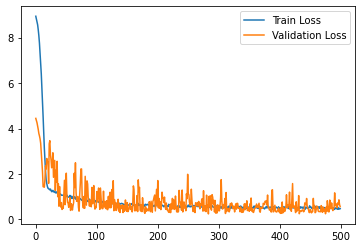

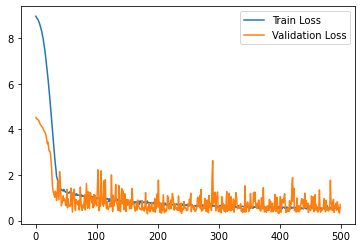

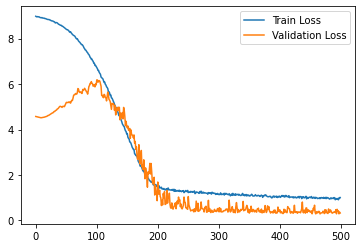

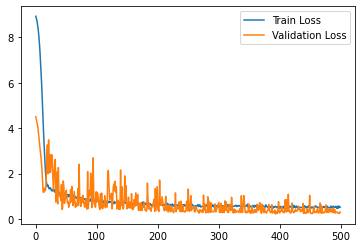

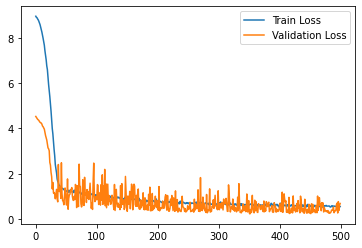

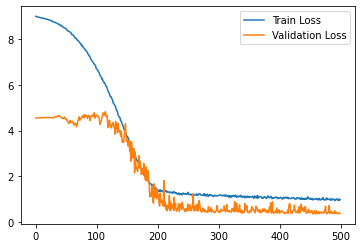

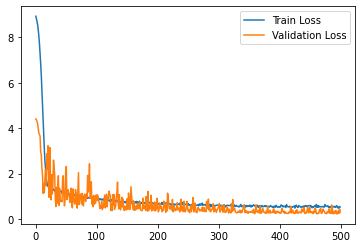

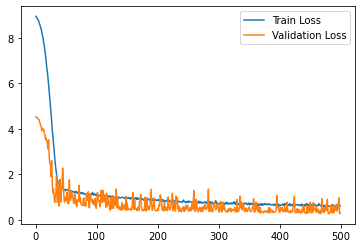

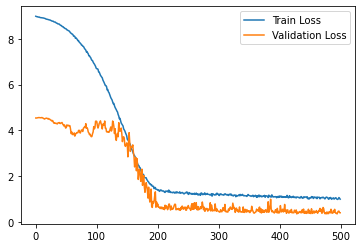

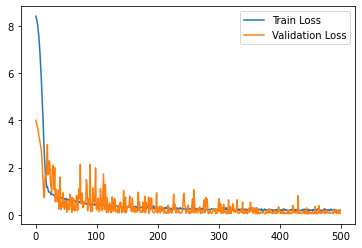

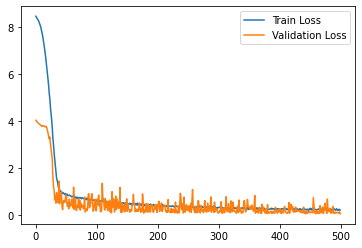

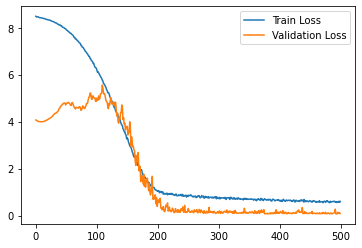

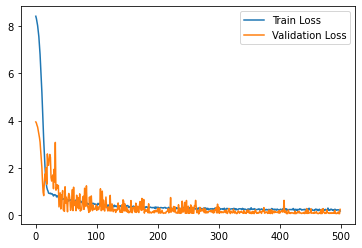

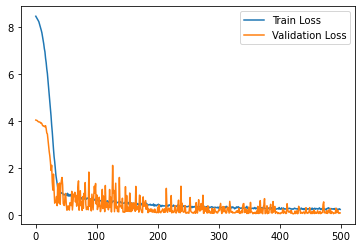

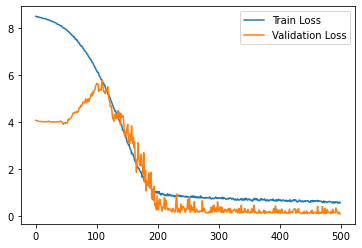

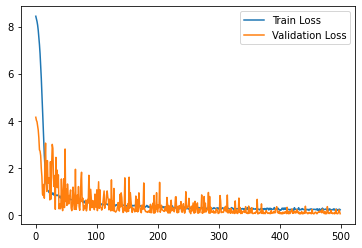

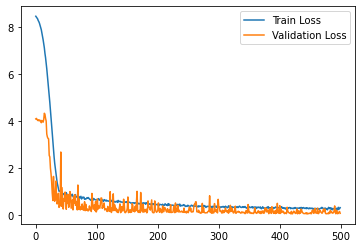

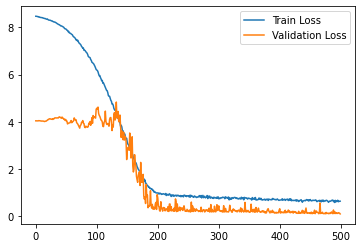

calculating for structure [256 128 128]


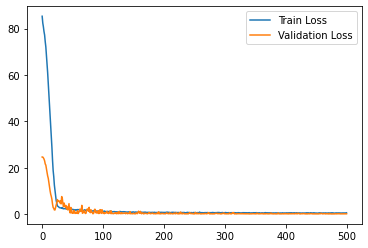

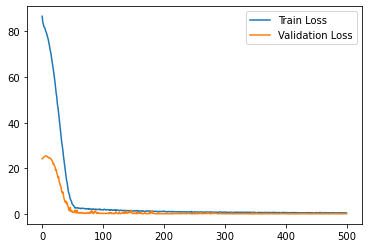

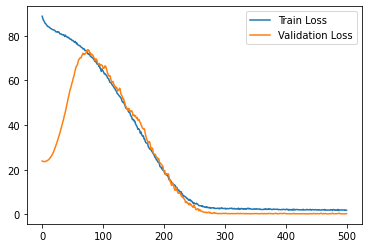

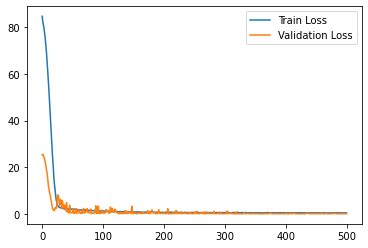

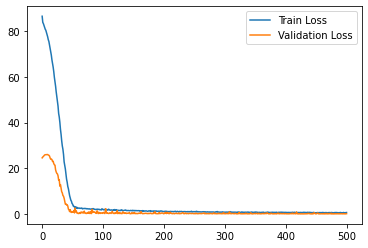

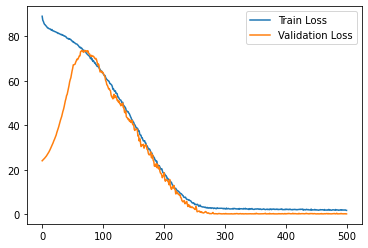

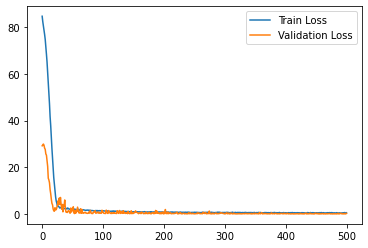

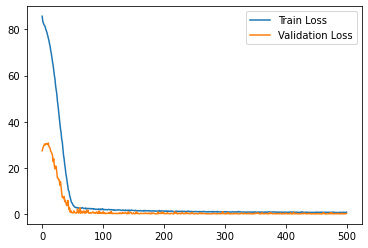

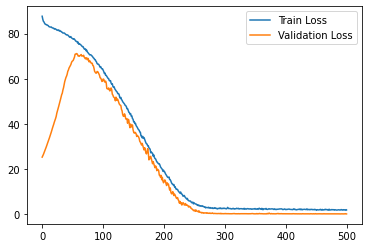

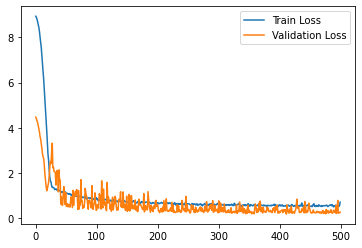

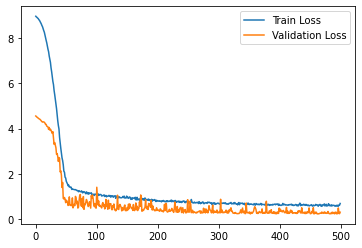

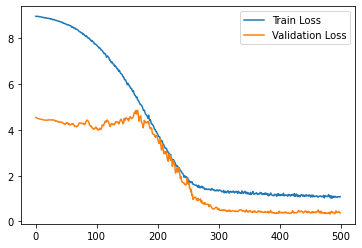

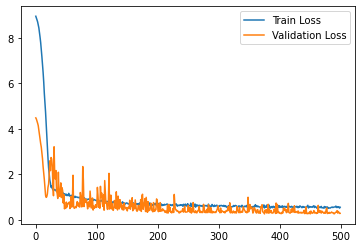

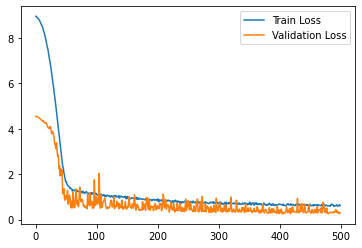

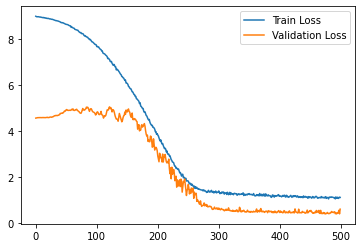

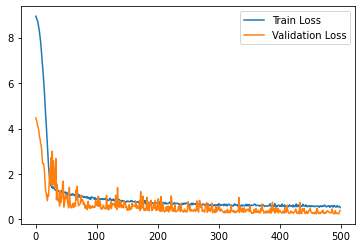

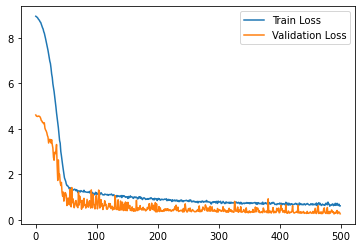

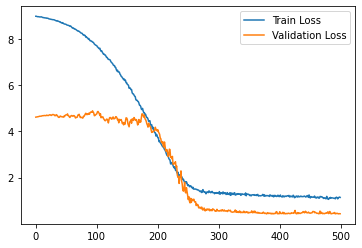

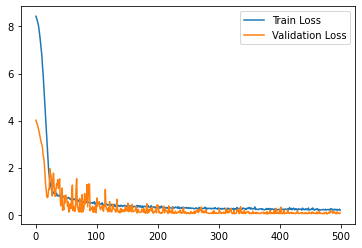

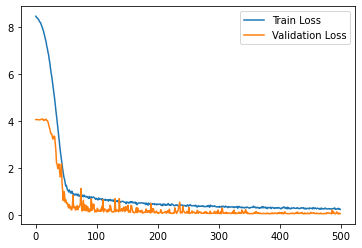

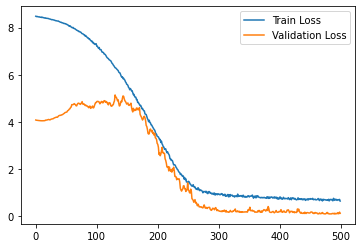

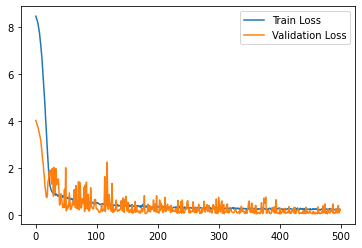

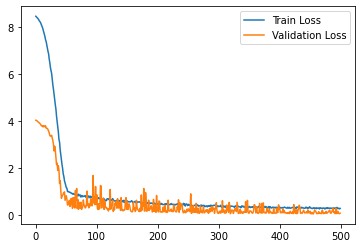

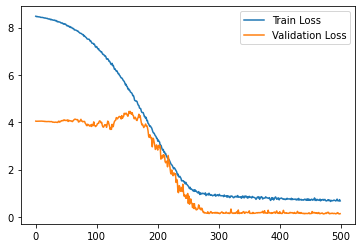

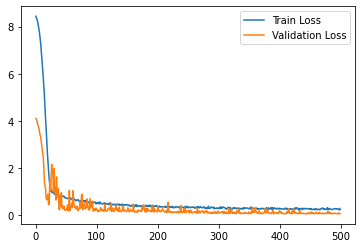

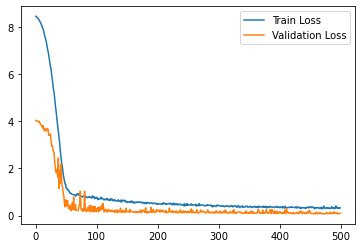

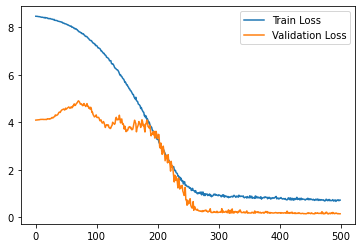

calculating for structure [128 128 128 128]


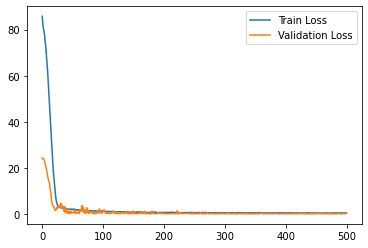

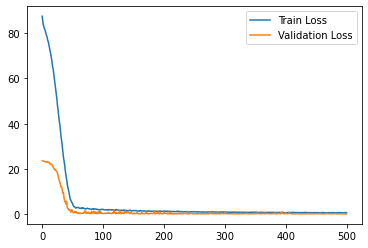

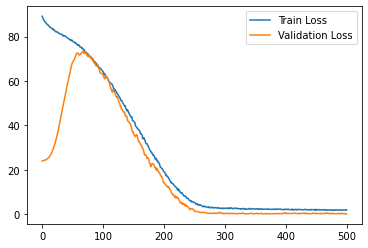

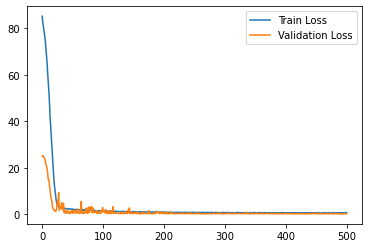

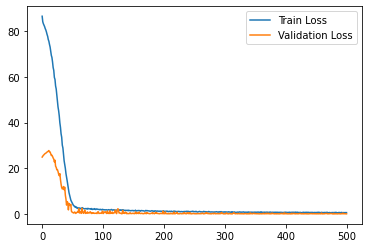

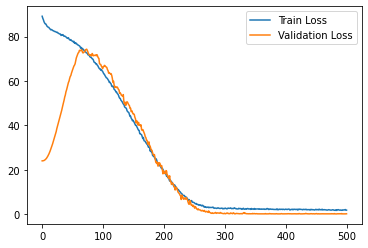

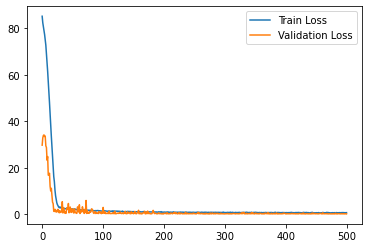

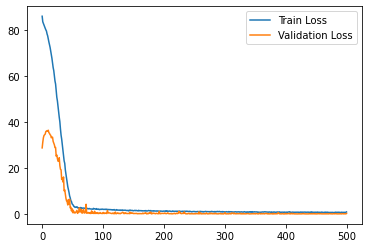

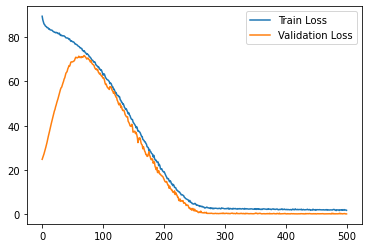

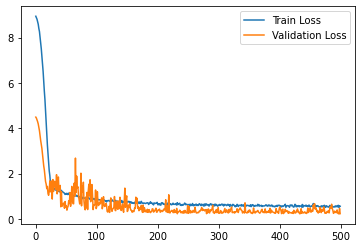

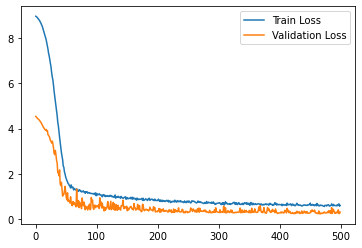

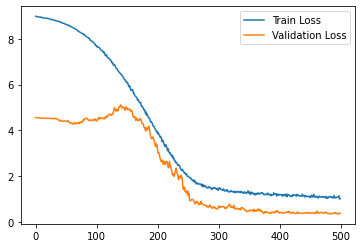

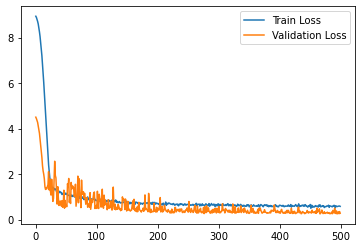

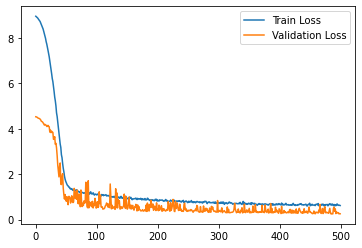

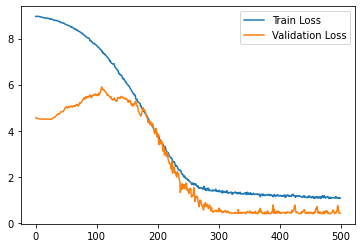

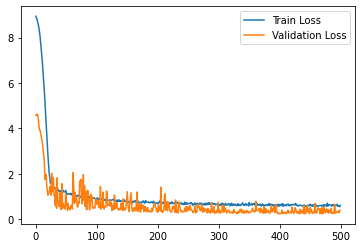

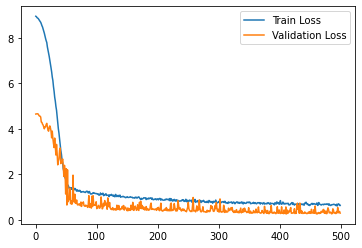

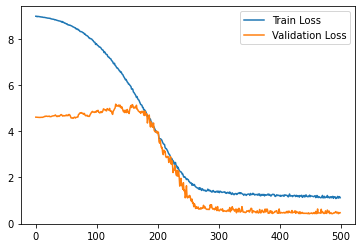

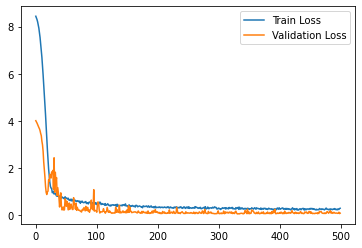

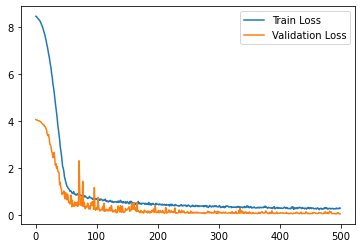

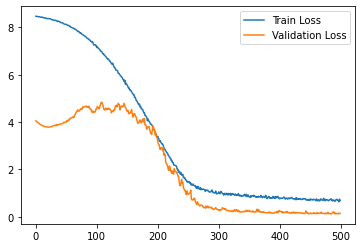

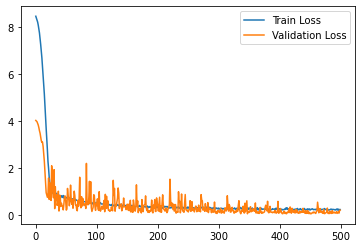

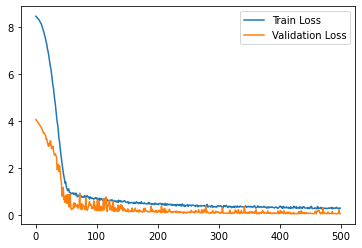

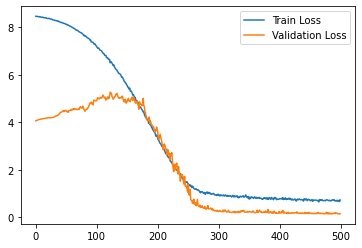

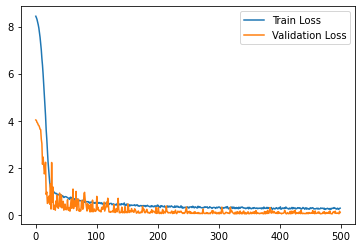

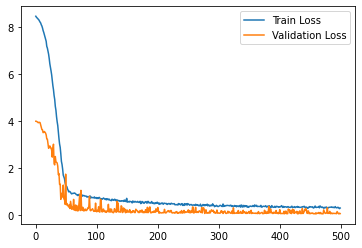

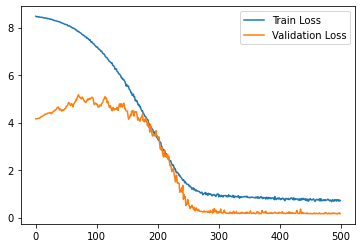

calculating for structure [256 256 128 128]


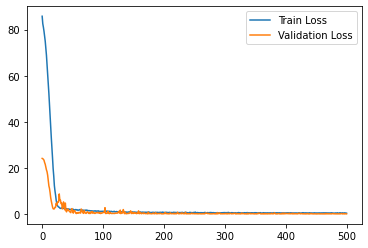

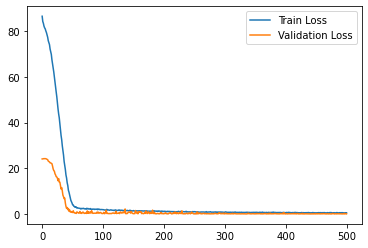

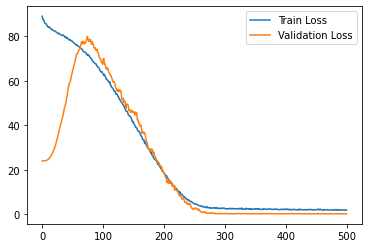

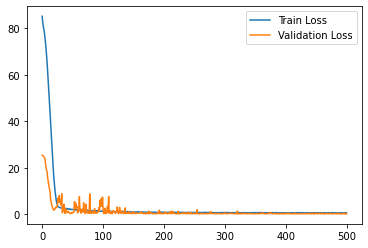

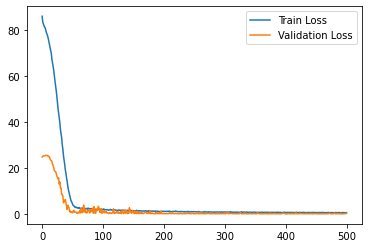

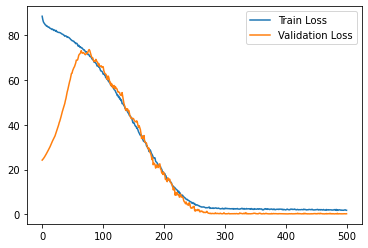

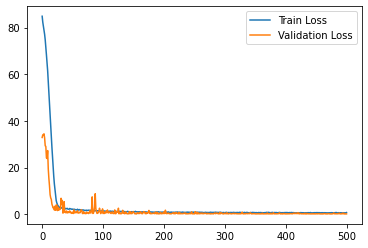

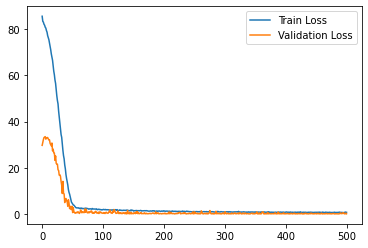

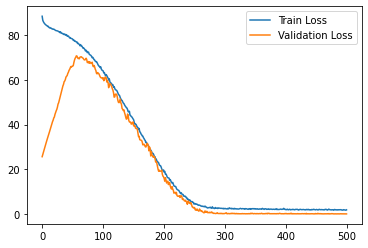

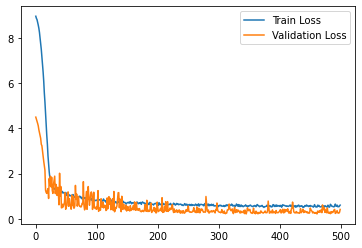

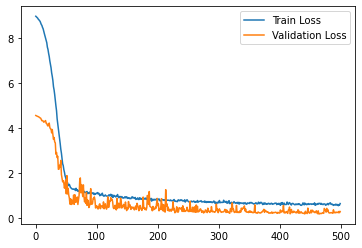

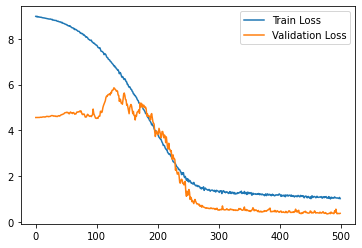

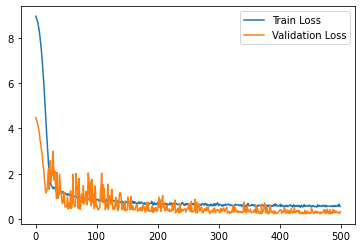

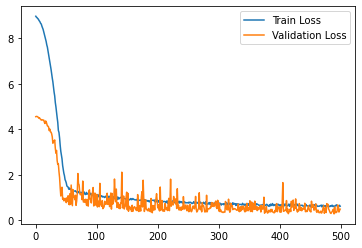

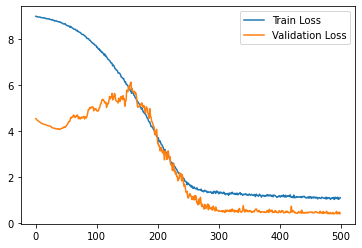

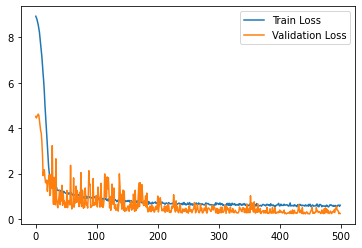

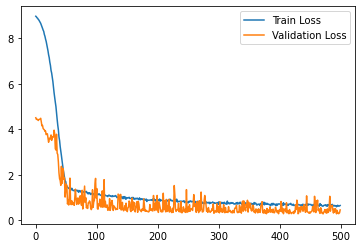

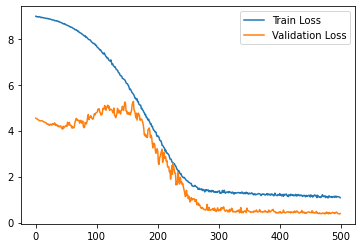

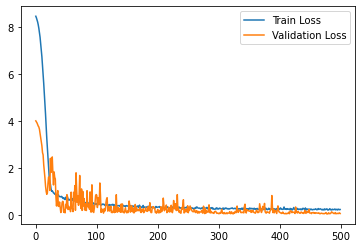

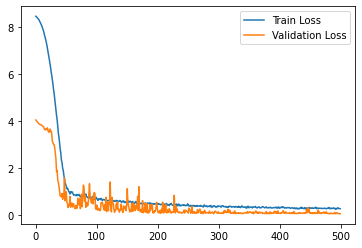

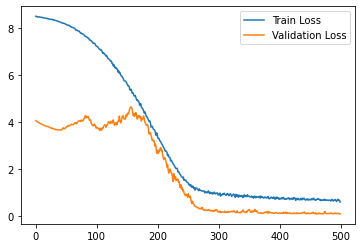

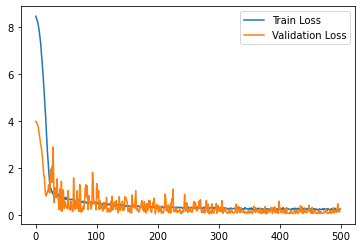

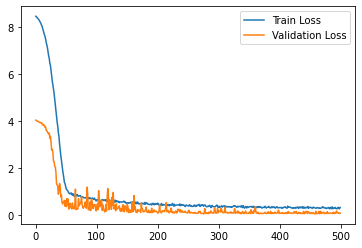

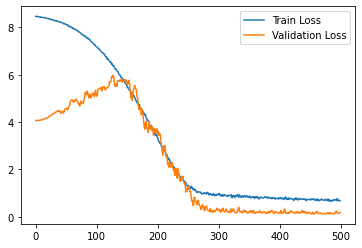

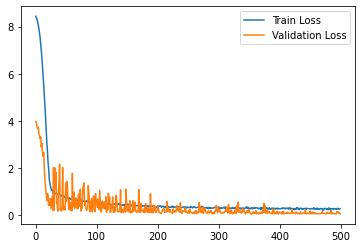

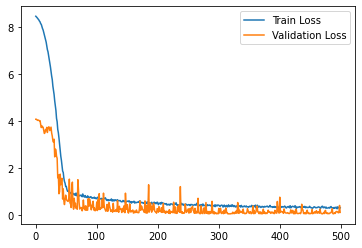

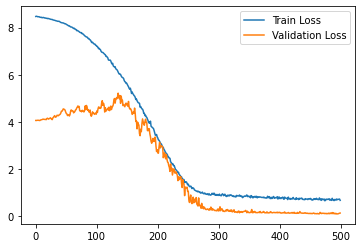

,structure,loss_function,mean_train_loss,mean_val_loss,mean_test_loss,activation,learning_rate,optimizer,dropout
0,[500],mse,0.341590,0.121574,0.626003,relu,0.0010,rmsprop,0.2
1,[500],mse,0.288202,0.112059,0.375155,relu,0.0005,rmsprop,0.2
2,[500],mse,0.555797,0.230095,0.432414,relu,0.0001,rmsprop,0.2
3,[500],mse,0.492777,0.377751,0.460199,leaky_relu,0.0010,rmsprop,0.2
4,[500],mse,0.408287,0.238045,0.503736,leaky_relu,0.0005,rmsprop,0.2
...,...,...,...,...,...,...,...,...,...
211,"[256, 256, 128, 128]",huber,0.318039,0.093793,0.169955,leaky_relu,0.0005,rmsprop,0.2
212,"[256, 256, 128, 128]",huber,0.688319,0.166129,0.254254,leaky_relu,0.0001,rmsprop,0.2
213,"[256, 256, 128, 128]",huber,0.260769,0.065741,0.170471,elu,0.0010,rmsprop,0.2
214,"[256, 256, 128, 128]",huber,0.314214,0.138238,0.216473,elu,0.0005,rmsprop,0.2


In [6]:
architectures = [np.array([500]), np.array([256]), np.array([256, 128]), np.array([256, 256]), np.array([256, 256, 256]), 
                 np.array([256, 128, 128]), np.array([128, 128, 128, 128]), np.array([256, 256, 128, 128])]
activations = ['relu', 'leaky_relu', 'elu']
#dropouts = [0.2, 0.5]
drop = 0.2
learning_rates = [0.001, 0.0005, 0.0001]
loss_functions = ['mse', 'mae', 'huber']

results = pd.DataFrame(columns = ['structure', 'loss_function', 'mean_train_loss', 'mean_val_loss', 'mean_test_loss', 'activation', 'learning_rate', 'optimizer', 'dropout'])

X_train, Y_train = normalize_temp(train)
X_test, Y_test = normalize_temp(test_set)

#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=150, verbose=1, restore_best_weights=True)
index = 0
n_runs = 3

for structure in architectures:
    print(f'calculating for structure {structure}')
    
    for loss in loss_functions:
        for activ in activations:
            for lr in learning_rates:
                    
                train_loss, val_loss, score = np.zeros(n_runs), np.zeros(n_runs), np.zeros(n_runs)
                    
                for run in range(n_runs):
                        
                    model = build_model(units=structure, activation=activ, drop=0.2, optimizer='rmsprop', loss_function=loss, learning_rate=lr)
                    history = model.fit(x=X_train, y=Y_train, batch_size=64, epochs=500, verbose=False, validation_split=0.1)
    
                    train_loss[run] = history.history['loss'][-1]
                    val_loss[run] = history.history['val_loss'][-1]
                    score[run] = model.evaluate(X_test, Y_test, verbose=0)
                    
                results.loc[index] = [structure, loss, train_loss.mean(), val_loss.mean(), score.mean(), activ, lr, 'rmsprop', drop]
                index += 1 
                    
                plt.plot(history.history['loss'], label='Train Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.legend()
                plt.show()

results 

In [7]:
results

,structure,loss_function,mean_train_loss,mean_val_loss,mean_test_loss,activation,learning_rate,optimizer,dropout
0,[500],mse,0.341590,0.121574,0.626003,relu,0.0010,rmsprop,0.2
1,[500],mse,0.288202,0.112059,0.375155,relu,0.0005,rmsprop,0.2
2,[500],mse,0.555797,0.230095,0.432414,relu,0.0001,rmsprop,0.2
3,[500],mse,0.492777,0.377751,0.460199,leaky_relu,0.0010,rmsprop,0.2
4,[500],mse,0.408287,0.238045,0.503736,leaky_relu,0.0005,rmsprop,0.2
...,...,...,...,...,...,...,...,...,...
211,"[256, 256, 128, 128]",huber,0.318039,0.093793,0.169955,leaky_relu,0.0005,rmsprop,0.2
212,"[256, 256, 128, 128]",huber,0.688319,0.166129,0.254254,leaky_relu,0.0001,rmsprop,0.2
213,"[256, 256, 128, 128]",huber,0.260769,0.065741,0.170471,elu,0.0010,rmsprop,0.2
214,"[256, 256, 128, 128]",huber,0.314214,0.138238,0.216473,elu,0.0005,rmsprop,0.2


In [8]:
results.to_excel("results_tuning_rmsprop.xlsx", index=False)